In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mediapipe as mp
# import keras
import os
import cv2 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pickle

In [54]:
train_dir="videodata/train"
test_dir="videodata/test"

In [55]:
mp_holistic = mp.solutions.holistic 
mp_drawing = mp.solutions.drawing_utils 

In [56]:
for direct in os.listdir(train_dir):
    for v in range(50):
        if os.path.exists(train_dir+'/'+direct+'/'+str(v)):
            pass
        else:
            os.mkdir(train_dir+'/'+direct+'/'+str(v))
            fc=0
            cap=cv2.VideoCapture(train_dir+'/'+direct+'/'+str(v)+'.mp4') 
            with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
                while True:
                    ret, frame = cap.read()
                    if frame is None:
                        break
                    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) 
                    image.flags.writeable = False                  
                    results = holistic.process(image)                
                    image.flags.writeable = True                   
                    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
                    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
                    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
                    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
                    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
                    result_test = np.concatenate([pose, face, lh, rh])
                    npy_path = train_dir+'/'+direct+'/'+str(v)+'/'+str(fc)+'.npy'
                    fc+=1
                    np.save(npy_path, result_test)          
            # cap.release()

In [57]:
classes=np.array(['Hello','ILoveyou','Thankyou'])

In [58]:
label_map = {label:num for num, label in enumerate(classes)}
print(label_map)

{'Hello': 0, 'ILoveyou': 1, 'Thankyou': 2}


In [59]:
sequences, labels = [], []
for action in classes:
    for v in range(50):
        window = []
        for fc in range(60):
            res = np.load(train_dir+'/'+action+'/'+str(v)+'/'+str(fc)+'.npy')
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [60]:
X = np.array(sequences)

In [61]:
Y = to_categorical(labels).astype(int)

In [62]:
X.shape

(150, 60, 1662)

In [63]:
Y.shape

(150, 3)

In [64]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)

In [65]:
x_train.shape

(135, 60, 1662)

In [66]:
x_test.shape

(15, 60, 1662)

In [67]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [68]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(60,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(classes.shape[0], activation='softmax'))

In [69]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [70]:
lstm_history=model.fit(x_train, y_train, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000
5/5 [==============================] - 6s 169ms/step - loss: 17.4510 - categorical_accuracy: 0.3259
Epoch 2/2000
5/5 [==============================] - 1s 154ms/step - loss: 23.6266 - categorical_accuracy: 0.2741
Epoch 3/2000
5/5 [==============================] - 1s 151ms/step - loss: 57.5254 - categorical_accuracy: 0.4000
Epoch 4/2000
5/5 [==============================] - 1s 155ms/step - loss: 229.8265 - categorical_accuracy: 0.3704
Epoch 5/2000
5/5 [==============================] - 1s 139ms/step - loss: 54.5257 - categorical_accuracy: 0.3407
Epoch 6/2000
5/5 [==============================] - 1s 146ms/step - loss: 291.8763 - categorical_accuracy: 0.3111
Epoch 7/2000
5/5 [==============================] - 1s 142ms/step - loss: 2031.7769 - categorical_accuracy: 0.3185
Epoch 8/2000
5/5 [==============================] - 1s 147ms/step - loss: 3428.6987 - categorical_accuracy: 0.3333
Epoch 9/2000
5/5 [==============================] - 1s 154ms/step - loss: 617.2433 - categ

In [71]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 60, 64)            442112    
                                                                 
 lstm_4 (LSTM)               (None, 60, 128)           98816     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 3)                 99        
                                                                 
Total params: 596,675
Trainable params: 596,675
Non-tr

Text(0, 0.5, 'Accuracy')

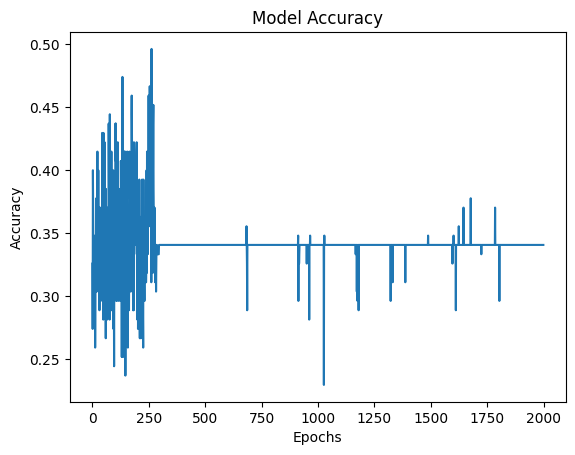

In [72]:
plt.plot(lstm_history.history['categorical_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

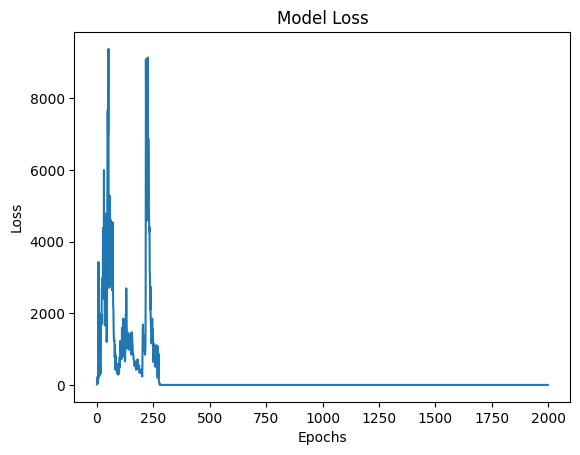

In [73]:
plt.plot(lstm_history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [74]:
res = model.predict(x_test)

1/1 [==============================] - 1s 899ms/step


In [75]:
classes[np.argmax(res[4])]

'ILoveyou'

In [76]:
classes[np.argmax(y_test[4])]

'Thankyou'

In [77]:
model_json = model.to_json()
with open("action.json", "w") as json_file:
    json_file.write(model_json)
model.save('action.h5')

In [78]:
from keras.models import model_from_json
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
json_file = open("action.json", "r")
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)
model.load_weights("action.h5")

In [80]:
yhat = model.predict(x_test)


1/1 [==============================] - 1s 681ms/step


In [81]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [82]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[11,  0],
        [ 4,  0]],

       [[ 0, 11],
        [ 0,  4]],

       [[ 8,  0],
        [ 7,  0]]], dtype=int64)

In [83]:
accuracy_score(ytrue, yhat)

0.26666666666666666

In [85]:
sequence = []
sentence = []
threshold = 0.8

cap = cv2.VideoCapture(0) 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while True:
        ret, frame = cap.read()
        if frame is None:
            break
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) 
        image.flags.writeable = False                  
        results = holistic.process(image)                
        image.flags.writeable = True                   
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
        pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
        face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
        lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
        rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
        result_test = np.concatenate([pose, face, lh, rh])
        sequence.append(result_test)
        sequence = sequence[-60:]
        
        if len(sequence) == 60:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if classes[np.argmax(res)] != sentence[-1]:
                        sentence.append(classes[np.argmax(res)])
                else:
                    sentence.append(classes[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        cv2.imshow('OpenCV Feed', image)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()


1/1 [==============================] - 0s 34ms/step
